In [1]:
import av
import cv2
import numpy as np
import pandas as pd

In [15]:
images_av = []
images_cv2 = []


In [16]:
%%timeit
container = av.open("./videos/WUzgd7C1pWA.mp4")
for frame in container.decode(video=0):
    images_av.append(frame.to_rgb().to_ndarray())



455 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
cap = cv2.VideoCapture("./videos/WUzgd7C1pWA.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        images_cv2.append(frame)
    else:
        break
cap.release()

188 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
images_av = []
images_cv2 = []
container = av.open("./videos/WUzgd7C1pWA.mp4")
for frame in container.decode(video=0):
    images_av.append(frame.to_rgb().to_ndarray())

cap = cv2.VideoCapture("./videos/WUzgd7C1pWA.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is True:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        images_cv2.append(frame)
    else:
        break
cap.release()

In [19]:

print(len(images_av), len(images_cv2))

327 327


In [1]:
import torchvision
torchvision.set_video_backend("video_reader")

In [2]:
vframes, _, _ = torchvision.io.read_video("./videos/WUzgd7C1pWA.mp4")
vframes.size()

/Users/bjuncek/bin/conda/envs/video_benchmark/lib/python3.7/site-packages/torchvision-0.8.0a0+9b80465-py3.7-macosx-10.9-x86_64.egg/torchvision/io/_video_opt.py:479: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


torch.Size([327, 256, 340, 3])

# Simple measurement of python overhead

In [1]:
# first, import torch
import torch

In [2]:
%%timeit
# torch multitensor
a = torch.zeros(1000, 3, 112, 112)

70.4 ms ± 5.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
# for loop with array allocation
test = []
for i in range(1000):
    test.append(torch.zeros(3, 112, 112))

93 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%timeit
# for loop with array allocation and stacking
test = []
for i in range(1000):
    test.append(torch.zeros(3, 112, 112))
a = torch.stack(test)


179 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/Users/bjuncek/bin/conda/envs/video_benchmark/lib/python3.7/site-packages/torchvision/__init__.py:64: UserWarning: video_reader video backend is not available
  warnings.warn("video_reader video backend is not available")


## Plotting the results
csv obtained by running `python timit_torch_zeros.py`

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df_e = pd.read_csv("torch_empty_speed.csv")
df_e["tensor_constructor"] = "torch.empty"
df_z = pd.read_csv("torch_zeros_speed.csv")
df_z["tensor_constructor"] = "torch.zeros"
df_o = pd.read_csv("torch_ones_speed.csv")
df_o["tensor_constructor"] = "torch.ones"


df = pd.concat([df_e, df_z, df_o])
df.head()

,Unnamed: 0,method,k,time,tensor_constructor
0,0,single_tensor,5,0.000008,torch.empty
1,1,single_tensor,10,0.000004,torch.empty
2,2,single_tensor,50,0.000004,torch.empty
3,3,single_tensor,100,0.000004,torch.empty
4,4,single_tensor,500,0.000004,torch.empty


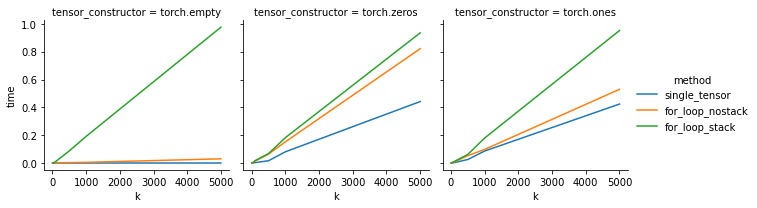

In [21]:
g = sns.FacetGrid(df, col="tensor_constructor", col_wrap=3, hue="method")
g = g.map(plt.plot, "k", "time").add_legend()

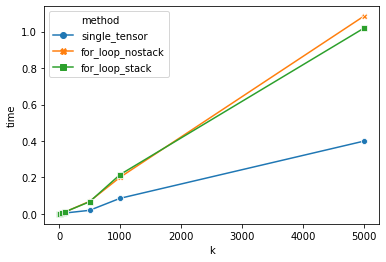

In [9]:
ax = sns.lineplot(x="k", y="time",
                  hue="method", style="method",
                  markers=True, dashes=False, data=df)

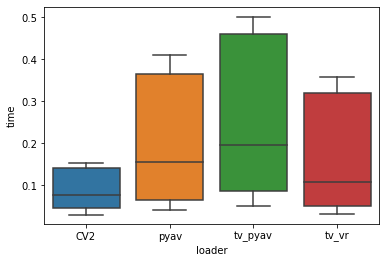

In [5]:
df = pd.read_csv("pyav_basic_speeds.csv")
ax = sns.boxplot(x="loader", y="time", data=df)
# print(df)